## Long-Short-Term-Memory Recurrent Neural Net Practice

Here's a quick tutorial out of the "Deep-Learning with Python" textbook, this involves using a recurrent neural network to predict temperatures and weather forecasts from the given data set


In [2]:
# Let's first start by importing the libraries and data we'll need
# Libraries needed include numpy, keras, csv, matplotlib

import numpy as np
import keras
import csv
from matplotlib import pyplot as plt

# Need to first import the data into a numpy array so we can do some work with it

fname = 'jena_climate_2009_2016.csv'
f = open(fname)
data = f.read();
f.close

# Now need to separate the column headers from the rest of the data

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

Using TensorFlow backend.


## Data Parsing

Now we need to parse the data and throw it into a numpy array so we can then feed it into our neural network.

In [3]:
# Initialize an empty array that's the same size as our data

float_data = np.zeros((len(lines), len(header)-1))

# Will now use a loop to fill the empty array with our data

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:] = values

#Now just to make sure we didn't make a mistake anywhere here, will print out our data

print(float_data[1])
print(float_data[:,1])

[ 9.9657e+02 -8.4100e+00  2.6501e+02 -9.2800e+00  9.3400e+01  3.2300e+00
  3.0200e+00  2.1000e-01  1.8900e+00  3.0300e+00  1.3098e+03  7.2000e-01
  1.5000e+00  1.3610e+02]
[-8.02 -8.41 -8.51 ... -3.16 -4.23 -4.82]


## Data Analytics 

Here we will plot some of our data to see if we can see any obvious patterns. Best to do that before going right into the model creation so that we can ensure that the obvious patterns are indeed accounted for during that stage. Here will simply look at temperature versus time data.

14


Text(0, 0.5, 'Temperature [C]')

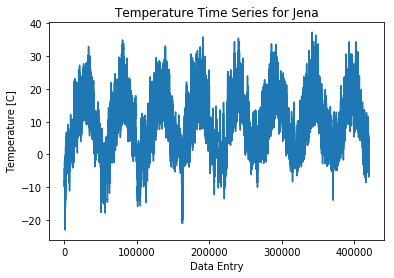

In [4]:
# Store our temperature data into a numpy array for convenience
print(float_data.shape[-1])
temp  = float_data[:,1] 
plt.plot(range(len(temp)), temp)
plt.title('Temperature Time Series for Jena')
plt.xlabel('Data Entry')
plt.ylabel('Temperature [C]')

As is evident from the plot above, we can see that the data typically fluctuates from about +35 to -20 degrees every 50000 entires or so. This will help guide us in developing an accurate recurrent neural network model as we can use this as a qualitative diagnostic for our model's performance.

## Data Preparation

Now we need to prepare our data to be fed into the model. Luckily for our purposes, we don't need to do much in the way of cleaning given the nature of the beast we're working with. If working on a text-based project, this would be where much of the cleaning and vectorization would occur.

In [6]:
# Three big objectives to accomplish here:
#1. Set a "lookback" period, or how far back we wish to go in the data set to make future predictions
#2. Set a number of steps to pick how often we want to sample, given that we have data recorded every 10 minutes, we should make it a bit simpler and maybe sample once an hour
#   Note: Can make above judgement call given the nature of our data, we don't expect much variation in temperature over the course of an hour, but might between hours so sampling once an hour makes sense
#3. Set a delay to tell our model how far into the future we wish to make a prediction for, given we're only using 5 days worth of historical data, wouldn't make sense to extend much further than a day into the future

# Will normalize our data so it all fits together properly and can be fed into our neural network properly

mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data/= std

# Now that we have normalized our data, now need to generate a time series for the adjusted data
# Will define a function with all the inputs we'll need for our recurrent neural network as it changes the data given to it 
# This function will need our normalized data array, our delay, min and max indices, shuffle command (do we want to randomly draw on the data each time or not?), the batch size of our data and the number of steps

def generator(data, lookback, delay , min_index, max_index, shuffle = False, batch_size = 128, step = 6):
    if max_index is None:
        max_index = len(data)  - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows), ))
        
        for j , row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

## Data Generation

Now that we defined a function with all the necessary parameters, can now go ahead and generate a training data set, a testing data set and a validation data set. This will be done below.

In [7]:
# Start by defining our lookback, step, batch size, and delay

# Go back 5 days into the data set
lookback  = 1440

# Pick one sample an hour
step = 6

# Make a prediction one day in the future
delay = 144

# Batch size will be 128 entries
batch_size = 128

# Now generating the data is as easy as passing in our variables in a function call to "generator" for each of the desired data sets

# Will start with the training data set, seems like an obvious place to start

train_gen=  generator(float_data, lookback=lookback, delay=delay, min_index=0,max_index=200000,shuffle=True,step=step,batch_size=batch_size)

# Will then create a validation data set using the exact same parameters, but shifting our indices up

val_gen=  generator(float_data, lookback=lookback, delay=delay, min_index=200001,max_index=300000,shuffle=False,step=step,batch_size=batch_size)

# And lastly will generate a testing data set 

test_gen=  generator(float_data, lookback=lookback, delay=delay, min_index=300001,max_index=None,shuffle=False,step=step,batch_size=batch_size)

#Set how many steps we need to get the entire validation data set
val_steps = (300000 - 200001 - lookback)

#Set how many steps we'll need to get the entire testing data set
test_steps = (len(float_data) -  300001 - lookback)

#Now that we have generated our data sets, it's a good time to make a few notes about this section

#1. Our batch sizes could really have been anything we wanted so long as everything matches up
#2. Our number of steps is also completely arbitrary, depends upon how much computing power you wish to use for your model, here the patterns are visually obvious, if that's not the case would want to keep as much of the data as possible
#3. Our lookback is also completely arbitrary, if you want to see if more complex relationships exist you might want to go back further than 5 days, again heavily contexual and a big judgement call
#4. Our delay was again, arbitrary, we could try and predict as far ahead into the future as we wish to see how our model performs at longer time periods, again, a judgement call
#5. Shuffling is completely optional, good to add it in to avoid overfitting as the model will eventually come to recognize the order of the data and make predictions accordingly, best to randomize it 
#6. If desired, can play around with indices to parse out interesting bits of the data and see what fun relationships and patterns emerge


In [23]:
next(train_gen)[1]

array([ 0.26802048,  0.19911338,  0.92546195, -0.38264324,  1.63599577,
        1.10055375, -1.87261798,  0.64644469, -0.68312336,  0.57188947,
       -0.71588247,  0.33127945, -0.95536287, -0.34197676, -1.22421351,
        1.102813  , -0.64358651,  0.20476151, -0.66730862, -0.29001403,
       -0.20077369, -1.74835928, -0.11718148, -0.70006773, -0.94971475,
       -0.70910473, -0.34084714, -1.01297372, -0.51706856, -0.86047441,
       -1.08188082, -1.05476983,  0.14150253, -1.38574981,  0.09066943,
        0.1629654 , -0.2561253 , -0.18382933,  0.08615093,  0.40131617,
        1.85740218,  0.59109309,  1.11410924,  0.78312926,  0.46118627,
        1.77268034,  0.03305858, -1.44223104,  1.28694179, -0.09120012,
        0.26011311,  0.75037015, -0.84804854,  2.01216073,  0.53348224,
        2.17934516, -0.52271668, -0.16236646, -0.57354979,  0.2691501 ,
        1.33551565, -0.30131028,  1.76251372,  0.48829726, -0.27194004,
       -1.21630614,  0.02402158,  0.25559461, -0.49560569, -1.15

## Optional Simplified Approach

This is a good place to add a simplfified approach, in the textbook they offer the use of a mean absolute error to see what the error is in the predicted temperature measurement. You could use other models, such as sequential neural networks or linear regressions here if you have a gut feeling it may be simpler. Of course, given that this is a tutorial, obviously we need to consider the use of recurrent neural networks. 

## Model Creation

Finally, after all the hard work of normalizing our data, taking a quick look at it, we get the to fun part: model creation. 

In [ ]:
# Need to import some libraries from keras to create our model
# This will involve the use of keras sequential neural network models, layers and rmsprop optimizers

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

# The rest is very similar to the creation of the sequential neural network we made during the Warm-Up project
# Quick refresher though, need to define our model with a number of layers, an optimzer function, a loss function, an activation function, and how many layers we want it to be

#Define our model as a sequential one
model = Sequential()

# Add some layers to our model 
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1))

# Now compile our model with optimizer and loss functions, no metric for this one though
model.compile(optimizer = RMSprop(), loss = 'mae')
history =  model.fit_generator(train_gen,
                               steps_per_epoch = 50,
                               epochs = 3,
                               validation_data = val_gen,
                               validation_steps = val_steps)

# Before we go any further, some important notes to make here. Will do that below in the "Model Notes" block

## Model Notes

1. Could have used other activation functions, 'relu' is a pretty popular one, but could use the likes of 'selu' and 'sigmoid'.

2. The number of layers we add is completely arbitrary and is usually driven by experimenting with the model to see what works the best for the project.

3. The number of epochs is another great place to play around. This is primarily due to wanting to avoid overfitting, which can happen by having too many training epochs. As such, should play around and see how many epochs yields the best result for the model.

4. The optimizer function is another area to play around as RMSprop may not always be the best choice for the project at hand.

5. The loss function selected here was another judgement call, but others could be used such as binary cross entropy. Used here since we actually have numbers to match to our model's prediction, so makes sense to use mean absolute error to see how far away our model's predictions are so we can mitigate the errors. Could also use root mean square method as well for the same purpose.

## Model Output

Will now plot our model's prediction against the actual data, and validation data to see if we're overfitting, and how our model is performing overall.

In [ ]:
# Will grab our losses by going into the training history and defining appropriate variables to make plotting easier

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Now plot our training and validation losses

plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Traing and Validation Losses By Epoch')
plt.legend()
plt.show()

In [ ]:
model.predict(float_data[1])

## GRU Model

Instead of flattening the time series data, let's remove the flattening and introduce a second type of recurrent neural network model, the GRU model. GRU models are like LSTM models, but they use "Gated Recurrent Unit" layers instead of flat ones. The chief difference is that it exploits temporal ordering/sequence of data to develop relationships, as opposed to assuming order was inconsequential.

In [ ]:
# Will use the same baseline for our GRU model creation as we did for our LSTM model with a few changes
# Will add a dropout rate and recurrent_dropout rate to say how many items were should drop per iteration and per recursion
# Will do this to drop a consistent number of items each time through the learning rpocess so the model "forgets" or drops pieces of data it determines to be useless

# Define our model as a sequential one
model = Sequential()

# Add some layers to our model 
model.add(layers.GRU(32,
                     dropout = 0.2,
                     recurrent_dropout = 0.2,
                     input_shape=(None, float_data.shape[-1])))
#model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1))

# Now compile our model with optimizer and loss functions, no metric for this one though
model.compile(optimizer = RMSprop(), loss = 'mae')
history =  model.fit_generator(train_gen,
                               steps_per_epoch = 500,
                               epochs = 40,
                               validation_data = val_gen,
                               validation_steps = val_steps)

## Model Analysis

Just as we did with our LSTM model, will plot our training and validation losses to see how our model is doing to see if we need to tweak some parameters like number of layers or training epochs.

In [ ]:
# Will grab our losses by going into the training history and defining appropriate variables to make plotting easier

loss = history.history['loss']
val_loss - history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Now plot our training and validation losses

plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Traing and Validation Losses By Epoch')
plt.legend()
plt.show()

## Stacked LSTM/GRU Model

Essentially the same as regular LSTM and GRU models, but takes advantage of the fact we've added a dropout function to improve "learning", or accuracy per epoch to add more layers or number of units per layer (neurons). Will explore this further in the code block below.

In [ ]:
# Will use the same baseline for our GRU model creation as we did for our LSTM model with a few changes
# Will add a dropout rate and recurrent_dropout rate to say how many items were should drop per iteration and per recursion
# Will do this to drop a consistent number of items each time through the learning rpocess so the model "forgets" or drops pieces of data it determines to be useless
# Will now add another parameter in the first layer that will return its sequence of outputs to stack onto the next layer
# Note GRU could be replaced with LSTM, the choice of GRU is somewhat arbitrary here 

# Define our model as a sequential one
model = Sequential()

# Add some layers to our model 
model.add(layers.GRU(32,
                     dropout = 0.2,
                     recurrent_dropout = 0.2,
                     return_sequences = True,
                     input_shape=(None, float_data.shape[-1])))

model.add(layers.GRU(64, activation = 'relu',
                    dropout = 0.1,
                    recurrent_dropout = 0.5))

model.add(layers.Dense(1))

# Now compile our model with optimizer and loss functions, no metric for this one though
model.compile(optimizer = RMSprop(), loss = 'mae')
history =  model.fit_generator(train_gen,
                               steps_per_epoch = 500,
                               epochs = 40,
                               validation_data = val_gen,
                               validation_steps = val_steps)

## Updated GRU/LSTM Model Analysis

Will also plot the previous model's output to evaluate its performance using its training and validation losses as we did before.

In [ ]:
# Will grab our losses by going into the training history and defining appropriate variables to make plotting easier

loss = history.history['loss']
val_loss - history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Now plot our training and validation losses

plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Traing and Validation Losses By Epoch')
plt.legend()
plt.show()

## Bi-directional Recurrent Neural Networks

Very important for Natural Language Processing projects, primarily because the neural network analyses how changing sequence/arrangement influences the outcome. This is accomplished by using two neural networks, one LSTM and one GRU, to analyze the relationship of the data when temporal signficance is excluded, and randomly included and merging the two outcomes. The order of these is completely arbitrary, and you may find excluding time significance first yields better results than if it had been preceded by a time/order significant neural network.

In [ ]:
# This is where things get a bit different will use the Bidirectional layer feature

# Define our model as a sequential one
model = Sequential()

# Add some layers to our model 
model.add(layers.Embedded(32, input_shape=(None, float_data.shape[-1])))

model.add(layers.Bidirectional(layers.LSTM(32)))

model.add(layers.Dense(1, activation = 'relu'))

# Now compile our model with optimizer and loss functions, no metric for this one though
model.compile(optimizer = RMSprop(), loss = 'mae')
history =  model.fit_generator(train_gen,
                               steps_per_epoch = 500,
                               epochs = 40,
                               validation_data = val_gen,
                               validation_steps = val_steps)

## Bidirectional Model Analysis

Will now plot our validation and training losses for our bidirectional model to see how it's been performing and whether or not we need to change some parameters.

In [ ]:
# Will grab our losses by going into the training history and defining appropriate variables to make plotting easier

loss = history.history['loss']
val_loss - history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Now plot our training and validation losses

plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Traing and Validation Losses By Epoch')
plt.legend()
plt.show()